# IEEE-CIS Fraud Detection

## Summary


## Notation

### Transaction Table 
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

### Identity Table
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.


They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import gc
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')

In [2]:
train_identity = pd.read_csv("../data/train_identity.csv")
train_transaction = pd.read_csv("../data/train_transaction.csv")
test_identity = pd.read_csv("../data/test_identity.csv")
test_transaction = pd.read_csv("../data/test_transaction.csv")
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
del train_identity, train_transaction, test_identity, test_transaction
gc.collect()

42

In [3]:
print("Training data shape", train.shape)
print("Training data columns name", list(train.columns))
train.head()

Training data shape (590540, 434)
Training data columns name ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [4]:
print("Testing data shape", test.shape)
print("Testing data columns name", list(test.columns))
train.head()

Testing data shape (506691, 433)
Testing data columns name ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V7

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [5]:
print("isFraud ratio is {}".format(sum(train["isFraud"])/len(train)))

isFraud ratio is 0.03499000914417313


### Check column's missing value 

In [6]:
train_missing_value_ratio_list = []
for key in train.columns:
    try:
        
        missing_value = sum(np.isnan(train[key]))/len(train)
        train_missing_value_ratio_list.append(missing_value)
#         print(key, missing_value) 
    except Exception as e:
        missing_value = sum(list(train[key] == "null") and list(pd.isna(train[key])))/len(train)
        train_missing_value_ratio_list.append(missing_value)
#         print(key, missing_value)

In [7]:
test_missing_value_ratio_list = []
for key in test.columns:
    try:
        missing_value = sum(np.isnan(test[key]))/len(test)
        test_missing_value_ratio_list.append(missing_value)
        print(key, missing_value)
    except Exception as e:
        missing_value = sum(list(test[key] == "null") and list(pd.isna(test[key])))/len(test)
        test_missing_value_ratio_list.append(missing_value)
        print(key, missing_value)

TransactionID 0.0
TransactionDT 0.0
TransactionAmt 0.0
ProductCD 0.0
card1 0.0
card2 0.017079442895176745
card3 0.0059247154577444635
card4 0.006090496969553436
card5 0.008973911121373777
card6 0.00593458340487595
addr1 0.1294852286699389
addr2 0.1294852286699389
dist1 0.5747427919580178
dist2 0.9280902956634319
P_emaildomain 0.13655659958436206
R_emaildomain 0.7318484046489873
C1 5.920768278891869e-06
C2 5.920768278891869e-06
C3 5.920768278891869e-06
C4 5.920768278891869e-06
C5 5.920768278891869e-06
C6 5.920768278891869e-06
C7 5.920768278891869e-06
C8 5.920768278891869e-06
C9 5.920768278891869e-06
C10 5.920768278891869e-06
C11 5.920768278891869e-06
C12 5.920768278891869e-06
C13 0.009370602596059532
C14 5.920768278891869e-06
D1 0.011902717829998953
D2 0.4633376160223884
D3 0.400918903236884
D4 0.151672321000373
D5 0.44282412752545436
D6 0.7537295906183453
D7 0.8813221470284651
D8 0.8532873092279121
D9 0.8532873092279121
D10 0.0247586793528995
D11 0.348374058351145
D12 0.863321037871207

V320 5.920768278891869e-06
V321 5.920768278891869e-06
V322 0.8491565865586719
V323 0.8491565865586719
V324 0.8491565865586719
V325 0.8491565865586719
V326 0.8491565865586719
V327 0.8491565865586719
V328 0.8491565865586719
V329 0.8491565865586719
V330 0.8491565865586719
V331 0.8491565865586719
V332 0.8491565865586719
V333 0.8491565865586719
V334 0.8491565865586719
V335 0.8491565865586719
V336 0.8491565865586719
V337 0.8491565865586719
V338 0.8491565865586719
V339 0.8491565865586719
id-01 0.7199338452824305
id-02 0.7296656147435024
id-03 0.8687938013503299
id-04 0.8687938013503299
id-05 0.7340588248064402
id-06 0.7340588248064402
id-07 0.990015611092362
id-08 0.990015611092362
id-09 0.8532873092279121
id-10 0.8532873092279121
id-11 0.7300563854499094
id-12 0.7199338452824305
id-13 0.7428689280054314
id-14 0.8591705793077044
id-15 0.7296636411540761
id-16 0.7518270504113947
id-17 0.7316589400640627
id-18 0.8995936379371254
id-19 0.7317773554296405
id-20 0.7323161453430197
id-21 0.99001561

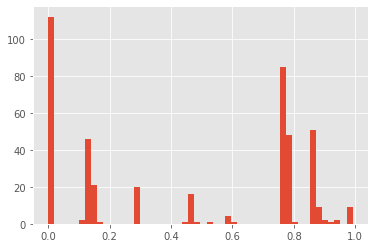

In [8]:
plt.hist(train_missing_value_ratio_list, bins=50)
plt.show()

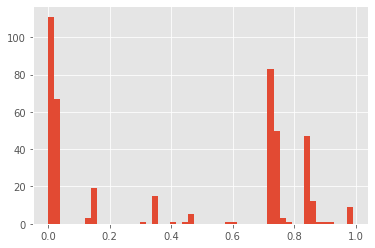

In [9]:
plt.hist(test_missing_value_ratio_list, bins=50)
plt.show()

In [10]:
lost_feature_num_list = [] 
cut_point_candidates = np.linspace(0,1, 50)
for cut_point in cut_point_candidates:
#     print(type(cut_point))
#     print(missing_value_ratio_list>cut_point)
    lost_feature_num_list.append(
        sum(missing_value_ratio_list>cut_point)/len(missing_value_ratio_list))
    

NameError: name 'missing_value_ratio_list' is not defined

In [ ]:
plt.plot(cut_point_candidates, lost_feature_num_list)
plt.title("elbow curve")
plt.show()

## Use the data without missing value

In [11]:
print("There are {} features without missing value in training data".format(sum(train_missing_value_ratio_list==np.float64(0))))

There are 20 features without missing value in training data


In [12]:
print("There are {} features without missing value in testing data".format(sum(test_missing_value_ratio_list==np.float64(0))))

There are 48 features without missing value in testing data


In [13]:
print(list(train.columns[train_missing_value_ratio_list==np.float64(0)]))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']


In [14]:
print(list(test.columns[test_missing_value_ratio_list==np.float64(0)]))

['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137']


In [77]:
np.unique(train['ProductCD'])

array(['C', 'H', 'R', 'S', 'W'], dtype=object)

In [78]:
np.unique(test['ProductCD'])

array(['C', 'H', 'R', 'S', 'W'], dtype=object)

In [41]:
all_train_x = train[
        [
#             'TransactionDT', 
            'TransactionAmt', 
            'ProductCD',
            'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']]
all_train_x = pd.get_dummies(all_train_x, columns=['ProductCD'])
all_train_y = train['isFraud']

In [42]:
train_x, test_x, train_y, test_y = train_test_split(
    all_train_x, all_train_y, test_size=0.3, random_state=42)

In [43]:
train_x.head()

,TransactionAmt,card1,C1,C2,C3,C4,C5,C6,C7,C8,...,C10,C11,C12,C13,C14,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
366215,49.000,17188,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,2.0,0.0,1.0,1.0,0,0,0,0,1
437716,20.534,17147,2.0,4.0,0.0,3.0,0.0,3.0,3.0,3.0,...,4.0,4.0,4.0,3.0,1.0,1,0,0,0,0
578692,22.000,16314,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0,0,0,1,0
364816,86.000,12598,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,2.0,0.0,9.0,1.0,0,0,0,0,1
223792,235.970,7482,111.0,101.0,0.0,0.0,120.0,66.0,0.0,0.0,...,0.0,73.0,0.0,444.0,96.0,0,0,0,0,1


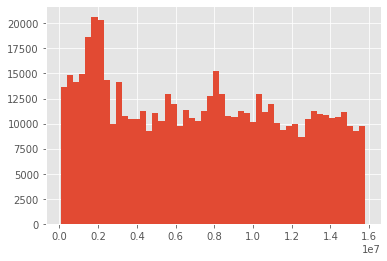

In [40]:
plt.hist(all_train_x["TransactionDT"], bins=50)
plt.show()

In [83]:
lgb_train = lgb.Dataset(
    train_x, 
    label=train_y,
    categorical_feature=['card1'],
    free_raw_data=False
)
lgb_test = lgb.Dataset(
    test_x, 
    label=test_y,
    categorical_feature=['card1'],
    free_raw_data=False
)

In [95]:
len(lgb_train.label)

413378

In [87]:
lgb_train.num_data()

LightGBMError: Cannot get num_data before construct dataset

In [74]:
def eval_average_precision(y_pred, train_data):
    """
    Fast auc eval function for lgb.
    """
    y_true = train_data.get_label()
    average_precision = average_precision_score(y_true, y_pred)
    return 'average precision', average_precision, True

In [75]:
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.05 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = ['binary_logloss', 'auc']         # or 'mae'
# params['metric'] = [eval_average_precision]
params['sub_feature'] = 0.50      
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 1

params['scale_pos_weight'] = (len(train) - sum(train["isFraud"]))/sum(train["isFraud"])
# params['set free_raw_data'] = False

In [76]:
bst = lgb.train(params, lgb_train, valid_sets=lgb_test, feval=eval_average_precision)

[1]	valid_0's binary_logloss: 0.145051	valid_0's auc: 0.8227	valid_0's average precision: 0.282227
[2]	valid_0's binary_logloss: 0.150068	valid_0's auc: 0.8358	valid_0's average precision: 0.322502
[3]	valid_0's binary_logloss: 0.15091	valid_0's auc: 0.878036	valid_0's average precision: 0.400523
[4]	valid_0's binary_logloss: 0.153467	valid_0's auc: 0.893863	valid_0's average precision: 0.43712
[5]	valid_0's binary_logloss: 0.158875	valid_0's auc: 0.89825	valid_0's average precision: 0.449576
[6]	valid_0's binary_logloss: 0.162625	valid_0's auc: 0.905776	valid_0's average precision: 0.471997
[7]	valid_0's binary_logloss: 0.168839	valid_0's auc: 0.90709	valid_0's average precision: 0.480456
[8]	valid_0's binary_logloss: 0.172605	valid_0's auc: 0.910553	valid_0's average precision: 0.48986
[9]	valid_0's binary_logloss: 0.176099	valid_0's auc: 0.912967	valid_0's average precision: 0.497326
[10]	valid_0's binary_logloss: 0.179953	valid_0's auc: 0.914516	valid_0's average precision: 0.50353

[83]	valid_0's binary_logloss: 0.258726	valid_0's auc: 0.937802	valid_0's average precision: 0.612136
[84]	valid_0's binary_logloss: 0.257906	valid_0's auc: 0.938042	valid_0's average precision: 0.613244
[85]	valid_0's binary_logloss: 0.257958	valid_0's auc: 0.938089	valid_0's average precision: 0.613905
[86]	valid_0's binary_logloss: 0.258131	valid_0's auc: 0.938151	valid_0's average precision: 0.61409
[87]	valid_0's binary_logloss: 0.257233	valid_0's auc: 0.938451	valid_0's average precision: 0.616078
[88]	valid_0's binary_logloss: 0.257396	valid_0's auc: 0.938503	valid_0's average precision: 0.616436
[89]	valid_0's binary_logloss: 0.257385	valid_0's auc: 0.938598	valid_0's average precision: 0.616743
[90]	valid_0's binary_logloss: 0.257395	valid_0's auc: 0.938678	valid_0's average precision: 0.617083
[91]	valid_0's binary_logloss: 0.256552	valid_0's auc: 0.938944	valid_0's average precision: 0.618488
[92]	valid_0's binary_logloss: 0.255613	valid_0's auc: 0.939209	valid_0's average p

In [96]:
bst.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('binary_logloss', 0.25445003262705135),
                          ('auc', 0.9398289383750458),
                          ('average precision', 0.6232146637819325)])})

In [30]:
cv_results = lgb.cv(params, lgb_train, nfold=5)

/home/wu/.local/share/virtualenvs/lightgbm-project-demo-blx0_w_h/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [31]:
cv_results.

{'cross_entropy-mean': [0.14230980088153128,
  0.1403202716107878,
  0.14533845283237629,
  0.148180129555512,
  0.1511994716362576,
  0.1562645041207459,
  0.16229305492297444,
  0.16808445402310832,
  0.17137701555781212,
  0.1766410340802679,
  0.1822742638455074,
  0.18523212286952198,
  0.1913832007310143,
  0.19372235121092446,
  0.19874321887937269,
  0.2007171724558127,
  0.20286109425782697,
  0.20495679731559355,
  0.2074572958105116,
  0.20995183245707408,
  0.21161042939008473,
  0.21361331252968557,
  0.21561675453601584,
  0.21774443542649363,
  0.2209393563306965,
  0.2238535408406413,
  0.22540863314430312,
  0.2285858443401026,
  0.2311981533717058,
  0.23411933992751915,
  0.23554317375790412,
  0.23804220799106646,
  0.24046255290749058,
  0.24306936440566568,
  0.24511768327070502,
  0.24719919682471697,
  0.24770239085562826,
  0.24768609763890512,
  0.24945628881120574,
  0.24990428252515867,
  0.2498586509893843,
  0.25141273838034955,
  0.253036390691154,
  0.25

## Reference
- [EDA and models](https://www.kaggle.com/artgor/eda-and-models#General-information)
- [kaggle discussion](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203)